In [281]:
"""LiuKatrina_11.ipynb Harvard MCB 112 Problem Set 11:  the adventure of the 2001 dimensions submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Nov 21, 2022"

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [283]:
# Code from sections and writeups on mcb112.org
def visualize_data(data, mu, C, outpng):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.plot( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    # for q in range(Q):
    #     ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    fig.savefig(outpng)
    
def plot_data_heatmap(X):
    '''
    Plot a heatmap of the data X.
    
    Input:
        X   Numpy array data matrix, where rows are observations, and columns are variables.
    '''
    max_intensity, min_intensity = np.max(X), np.min(X)

    plt.figure(figsize=(20,6))
    sns.heatmap(X, 
                cmap='Greys', vmin=min_intensity, vmax=max_intensity, 
                cbar_kws={'label': 'intensity', 'shrink': 0.75})
    plt.xlabel("Gene")
    plt.ylabel("Sample")
    plt.show()

# Exercise 1: Watson's K-means Result
First, we load the data, take the log data, and visualize it in a heatmap.

In [284]:
# Loading the data and prepare log data
data = pd.read_table("w11-data.tbl", delim_whitespace=True)
data = np.array(data)
data_log = np.log(data)

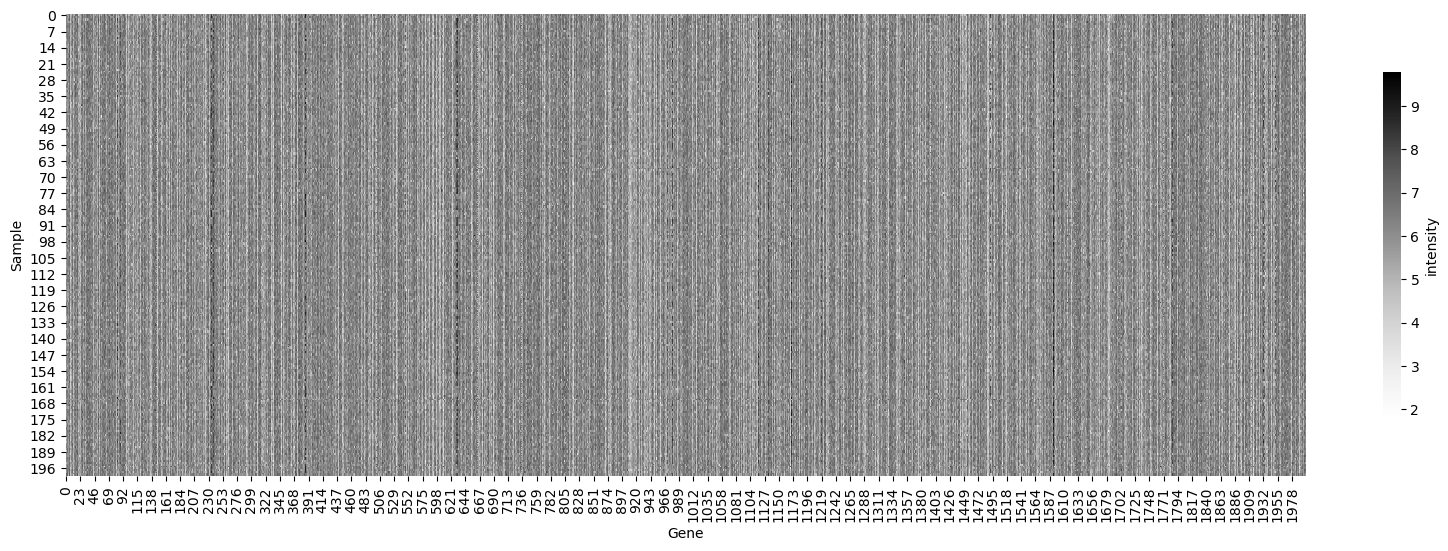

In [285]:
# Visualize the data in a heatmap
plot_data_heatmap(data_log)

Then, we borrow the code from week 5's assignment for KMeans clustering.

In [286]:
def euclid_dist(p1,p2):
    """
    Calculate the Euclidean distance between two data point
    :param p1: tuple/list-like 1-d array
    :param p2: tuple/list-like 1-d array
    :return: a scalar value representing the euclidean distances
    """
    return np.linalg.norm(p1-p2)

def assignment(data, centroids):
    """
    Perform the assignment step of kmeans and identify the cluster where each data point belongs 
    to based on the current input centroids
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param centroids: 1-d array of length k/clust_num
    :return: 1-d integer array of clustering assignment
    """
    clusters = np.zeros(data.shape[0])
    for i in range(len(data)):
        p = data[i]
        dists = [euclid_dist(p,c) for c in centroids]
        clusters[i] = min(enumerate(dists), key=lambda x: x[1])[0]
    return clusters.astype(int)

def update(data, clusters, prev_centroids=None):
    """
    Calculate the new centroids based on the clustering assignment
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param clusters: 1-d integer array of clustering assignment
    :param prev_centroids: 1-d array of length k/clust_num containing previous centroids used when
                            no data point is assigned to the group.
    :return: 1-d array of length k/clust_num containing centroids
    """
    clust_num = max(clusters)+1
    data_dim = data.shape[1]
    centroids = np.zeros((clust_num,data_dim))
    for i in range(clust_num):
        clust_data = data[np.where(clusters == i)]
        if len(clust_data) == 0 and prev_centroids is not None:
            centroids[i] = prev_centroids[i]
        else:
            centroids[i] = np.mean(clust_data, axis=0)
    return centroids

def kmeans(data, k, max_iter=50,init="random"):
    """
    Using the kmeans algorithm to cluster the input data into k groups
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: number of clusters
    :param max_iter: maximum number of iterations of assignments and upates
    :param init: initialization stategy
    :return: the cluster assignment, centroids caculated by kmeans algorithm.
    """
    data_dim = data.shape[1]
    init_centroids = data[:k,:]
    if init == "random":
        init_centroids = np.random.rand(k,data_dim)
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
        
        for i in range(data_dim):
            init_centroids[:,i] *= data_max[i]-data_min[i]
            init_centroids[:,i] += data_min[i]
    
    curr_centroids = init_centroids
    prev_assignment = assignment(data, curr_centroids)
    curr_assignment = prev_assignment

    for i in range(max_iter):
        curr_centroids = update(data, prev_assignment, curr_centroids)
        curr_assignment = assignment(data, curr_centroids)
        if np.array_equal(prev_assignment,curr_assignment):
            break
        prev_assignment = curr_assignment
    return curr_assignment, curr_centroids

def total_sqdist(data,centroids, clusters):
    """
    Calculate the total square distance based on the data, centroids obtained from model, 
    and cluster assignments
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param centroids: 1-d array of length k/clust_num
    :param clusters: 1-d integer array of clustering assignment
    :return: the total squared distance
    """
    total_dist = 0
    cluster_num = len(centroids)
    for i in range(data.shape[0]):
        p = data[i]
        c = centroids[clusters[i]]
        diff = c-p
        total_dist += np.inner(diff,diff)
    return total_dist

def find_min_tsqd(data,k, iter = 20):
    """
    Use total square distance as a metric to find the paramters of the best model
    :param data: 2-d numpy array of shape (data_num, data_dim)
    :param k: number of clusters
    :param iter: number of times model run with different initialized centroids 
    :return: lowest squared distance, 1-d integer array of best clustering assignment, 
            1-d array of length k/clust_num of best centroids
    """
    min_dist = np.Inf
    min_assignment = []
    min_centroids = []
    for _ in range(iter):
        asgn, cent = kmeans(data,k)
        sqd = total_sqdist(data, cent, asgn)
        if sqd < min_dist:
            min_dist = sqd
            min_assignment = asgn
            min_centroids = cent
    return min_dist, min_assignment, min_centroids

Apply the Kmeans algorithm to the log data and we get:

In [287]:
# Compute total squared distance from raw log data
res_dist, res_assign, res_C = find_min_tsqd(data_log,8)
print("From the raw log data, we applied kmeans and obtained an assignment with total squared distance of %f, which is similar to the total squared distance that Watson have of 87378.2.",res_dist)

From the raw log data, we applied kmeans and obtained an assignment with total squared distance of %f, which is similar to the total squared distance that Watson have of 87378.2. 87889.43237212772


# Exercise 2: Dimensionality reduction
We will first apply PCA algorithm to reduce the dimensions.

In [288]:
def PCA(data):
    """
    Apply PCA to the data
    :param data: a 2D numpy array of shape (sample_num, gene_num)
    :return: PCA processed data, U,S,W,W transpose,and eigenvalues
    """
    X_centered_data = data - np.mean(data, axis = 0)
    U, S, W_t     = np.linalg.svd(X_centered_data)
    W             = W_t.T
    PCs           = np.dot(X_centered_data, W)
    eigenvalues = np.square(S)/(data.shape[0]-1)
    return PCs, U, S, W, W_t, eigenvalues

In [289]:
# Apply PCA to the log data
PCs, U, S, W, W_t, eigenvalues = PCA(data_log)

We want to compare the eigenvalues to the negative control eigenvalues to verify there is actual clustering happening.

In [290]:
# load the negative control data
neg_control = pd.read_table("w11-eigen.tbl",header=None,index_col=0, delim_whitespace=True)

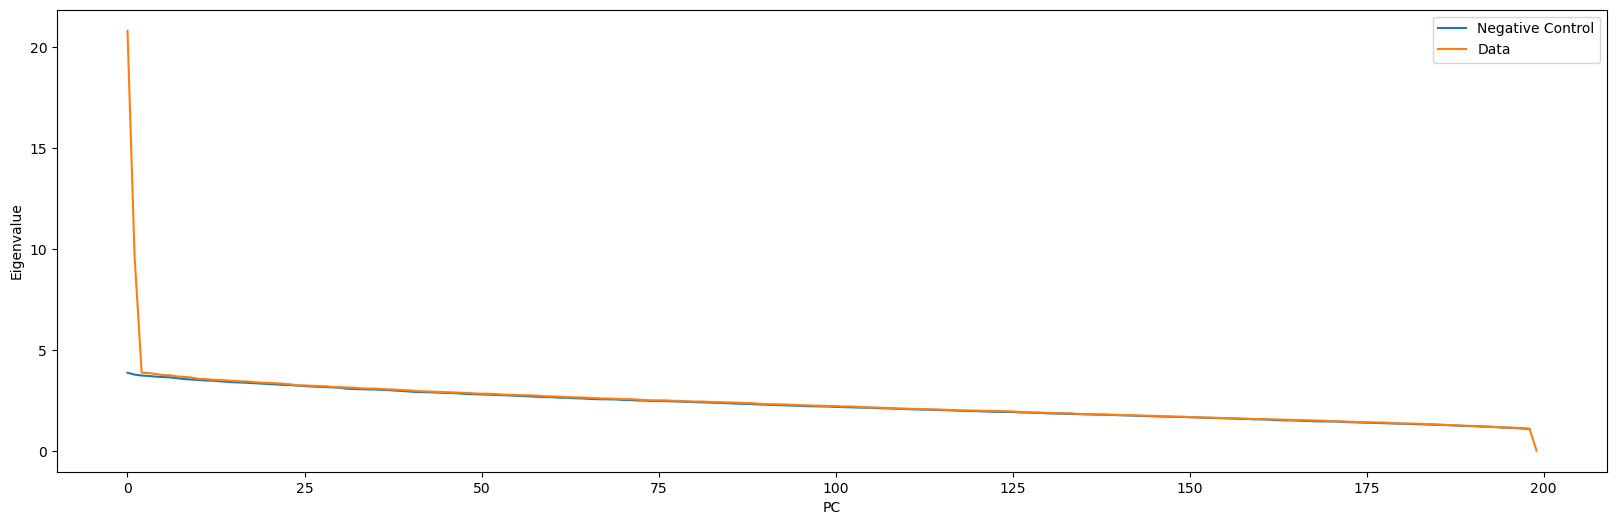

In [291]:
# Plot eigenvalues and negative control eigenvalues
plt.figure(figsize=(20,6))
plt.plot(range(len(neg_control)),neg_control, label="Negative Control")
plt.plot(range(len(eigenvalues)),eigenvalues, label="Data")
plt.legend()
plt.xlabel("PC")
plt.ylabel("Eigenvalue")
plt.show()

We see that from the comparison, there is significant clustering along the first two principal components where as the remaining PCs demonstrates little difference comparing to the negative control. We will further plot out the data to visually verify there is clustering.

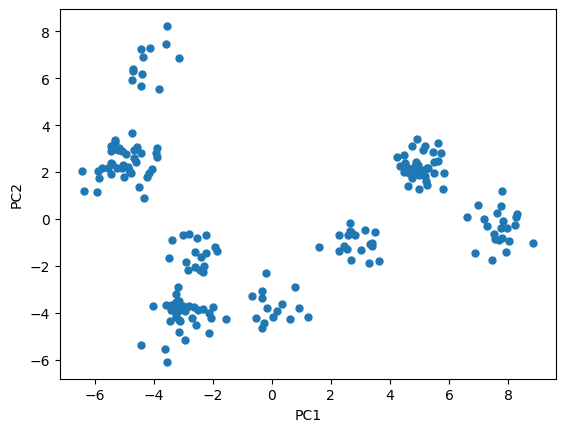

In [292]:
# Plot the log data in 2D of the first two PCs
plt.figure()
plt.plot(PCs[:,0],PCs[:,1],"o",ms="5")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

We can see there is 8 noticeable clusters. We will then use the total exlained variance to find the significant genes that contribute to the first two components. To do that, we first visualize them and try to determine a threshold.

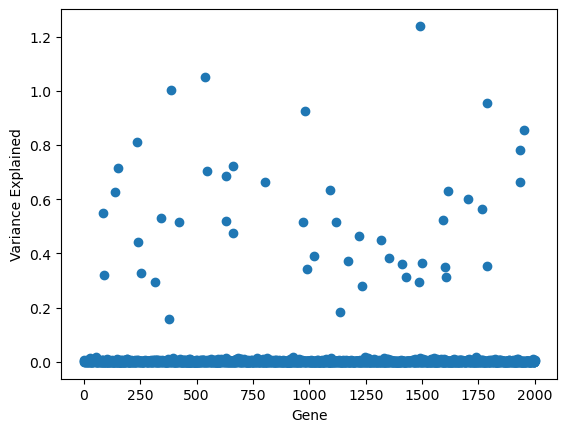

In [293]:
# Plot the variance in the first two PCs explained by each gene
var_explained = np.sum(np.dot(np.square(W[:,:2]),np.diag(eigenvalues[:2])),axis=1)
plt.figure()
plt.plot(var_explained,"o")
plt.xlabel("Gene")
plt.ylabel("Variance Explained")
plt.show()

From the plot, a reasonable threshold would be 0.1 for the total explained variance for significant genes.

In [294]:
# Count the number of significant genes
sig_genes = [v for v in var_explained if v>0.1]
print("We have a total of %d significant genes that contributes to the first two principal components"% len(sig_genes))

We have a total of 47 significant genes that contributes to the first two principal components


The genes are significant because of they contribute to the variance of data on the first PCs, which are confirmed having clustering information by comparing to the negative control eiganvalues.

# Exercise 3: Checking the K
First, we look at the data on the first two PCs with previous clustering assignment from KMeans on the raw log data.

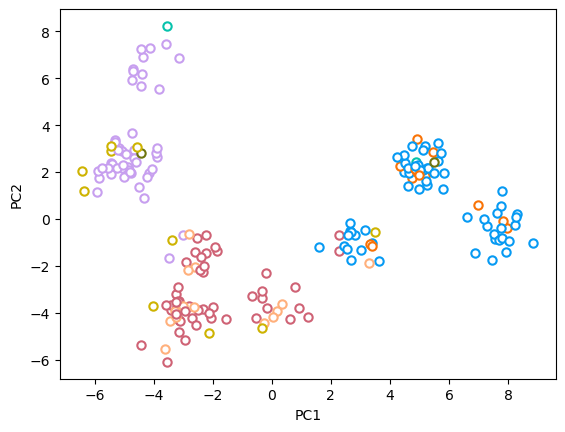

In [295]:
# Visualize the data in the first two PC with previous kmeans assignment
visualize_data(PCs[:,:2],res_C[:,:2],res_assign,"PC_hard_kmeans.png")

The assignment does not make sense. A possible explanation is that our data contains a lot of noise and which is minor, but they were factored into the distance calculation evenly. This results in the assignment being interfered and our solution is to cluster the first two PC data. We apply KMeans on the first two PC data to see if there is any difference.

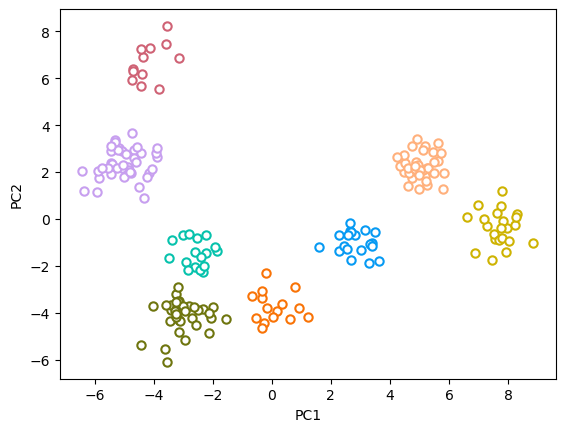

In [296]:
# Visualize the data in the first two PC with kmeans on PCA-ed data
PC_dist, PC_assign, PC_C = find_min_tsqd(PCs[:,:2],8)
visualize_data(PCs[:,:2],PC_C,PC_assign,"PC_kmeans.png")

The assignment from KMeans on the first two PC data represents the clusters well. 

# Exercise 4: Reconstruct Expression Pattern
We construct the data and plot it on a heatmap.

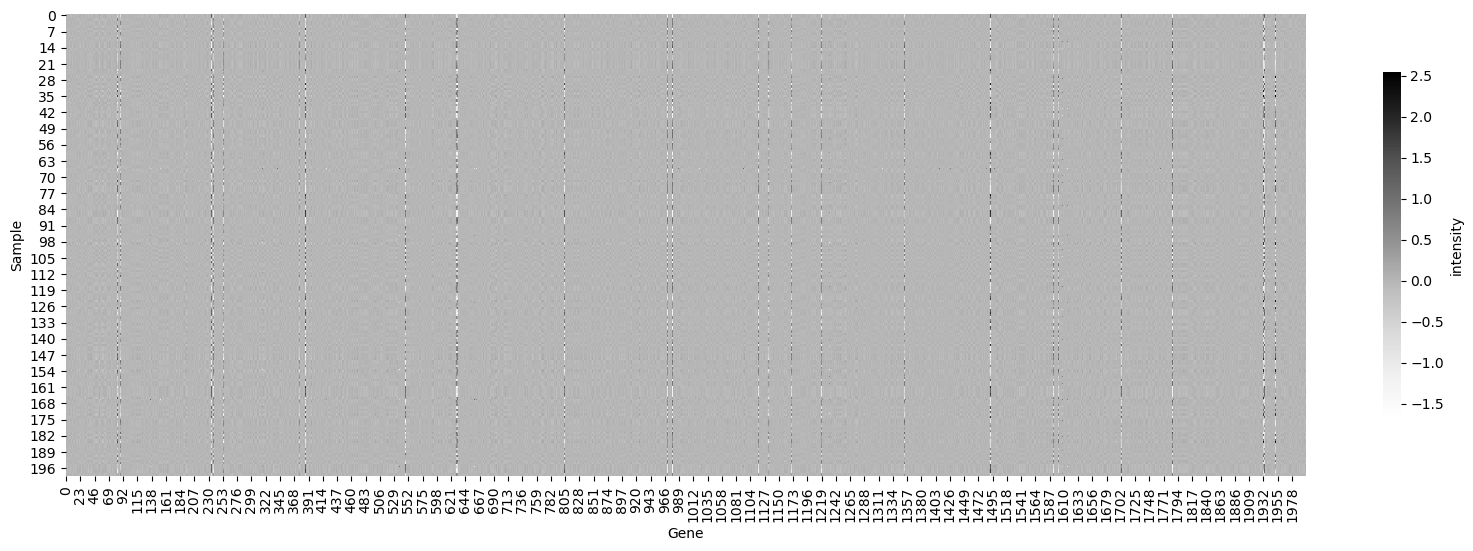

In [297]:
# Plot reconstructed data
new_data = U[:,:2]@np.diag(S[:2])@W_t[:2,:]
plot_data_heatmap(new_data)

We see that only significant genes has values explaining the difference between samples. We then try to cluster them by the clustering assignment from the first two PC data.

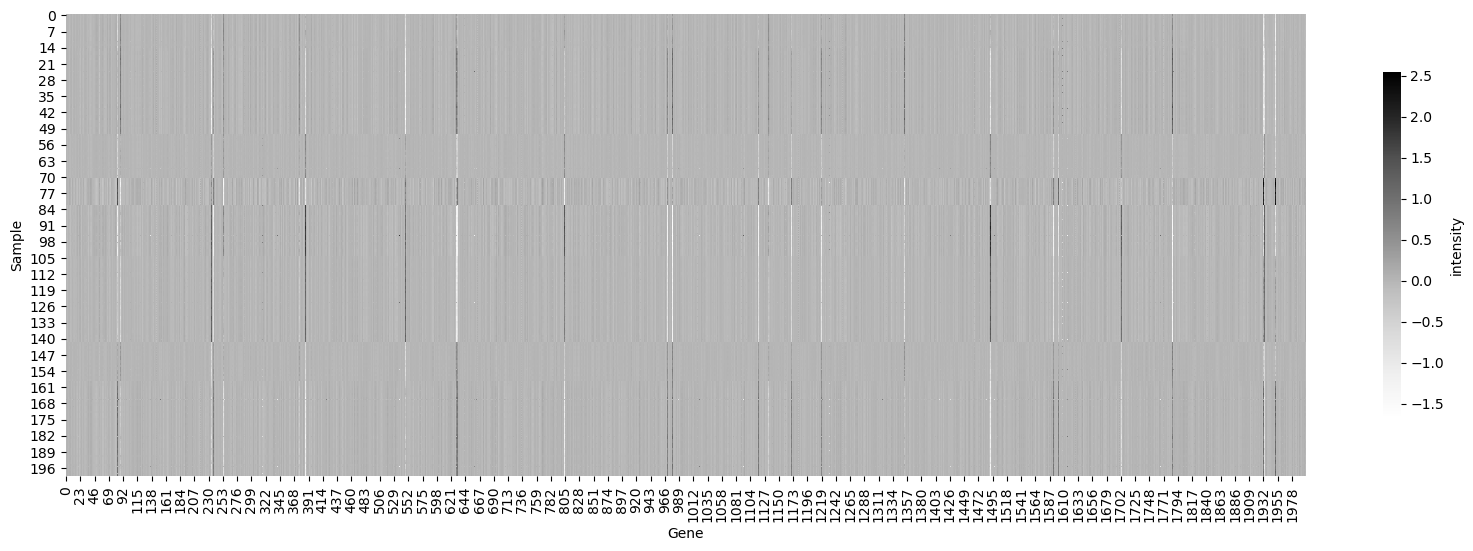

In [298]:
# Plot clustered reconstructed data
new_data_sorted = pd.DataFrame(new_data)
new_data_sorted["assignment"] = PC_assign
new_data_sorted = new_data_sorted.sort_values("assignment")
new_data_sorted.pop("assignment")
plot_data_heatmap(np.array(new_data_sorted))

The clustering definitely looks more obvious because it is represented through the y axis. We see that there are noticeable patterns across the samples based on the significant genes.